# Explore mapping statistics across barcodes
---

This can be improved, but is good enough for now.

In [72]:
import os
import sys
import configparser
import getopt
import numpy as np
import pandas as pd
from collections import Counter

from lib.error import *
from lib.mapping import *

In [73]:
from matplotlib import lines
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# inline stylization
%matplotlib inline
sns.set_style('white')
sns.set_style('ticks')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.figsize'] = [4, 4]

## 0 Settings

In [74]:
expt_dir = "../analysis/ont/zambia/2019-04-10"  # experiment of interest

If `save_figs` is set to `True`, then figures are automatically saved as `.png` under `../figs`, as well as visualized in the notebook.

In [75]:
save_figs = True
fig_dir = expt_dir.replace("analysis", "figs")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [76]:
print("Make Figures:", save_figs)
print("Figure path:", fig_dir)

Make Figures: True
Figure path: ../figs/ont/zambia/2019-04-10


## 1  Calculate mapping statistics

In [77]:
results_dir = expt_dir.replace("analysis", "results")

In [78]:
# Check number of .sorted.bam files produced
bams = [f for f in os.listdir(results_dir) if f.endswith("sorted.bam")]
bams.sort()
n_bams = len(bams)

In [79]:
bams_path = [os.path.join(results_dir, b) for b in bams]
mapping_stats = []
for b in bams_path:
    mapping_stats.append(get_mapping_statistics(b, verbose=False))

In [80]:
bam_info = ["%s: %d/%d (%.02f%%)" % (os.path.basename(b),
                                     dt["Mapped"],
                                     dt["Reads"],
                                     100*dt["Mapped"]/dt["Reads"])
            for (b, dt) in zip(bams_path, mapping_stats)]

In [81]:
bam_reads = [dt["Reads"] for dt in mapping_stats]
bam_mapped = [dt["Mapped"] for dt in mapping_stats]

In [82]:
print("Number of .bam: %d" % n_bams)
print(".bam statistics (uniquely mapped reads/total reads):")
print("\n".join(bam_info))
print("TOTAL: %d/%d (%.02f%%)" % (sum(bam_mapped), sum(bam_reads),
                                  100*sum(bam_mapped)/sum(bam_reads)))

Number of .bam: 7
.bam statistics (uniquely mapped reads/total reads):
BC01.sorted.bam: 299496/301170 (99.44%)
BC02.sorted.bam: 359944/361830 (99.48%)
BC03.sorted.bam: 291292/292729 (99.51%)
BC04.sorted.bam: 258986/260258 (99.51%)
BC05.sorted.bam: 304512/304999 (99.84%)
BC06.sorted.bam: 266430/267073 (99.76%)
none.sorted.bam: 79884/81051 (98.56%)
TOTAL: 1860544/1869110 (99.54%)


## 2 Plot

In [83]:
mapping_df = pd.DataFrame(mapping_stats)
mapping_df["ID"] = [b.split(".")[0] for b in bams]
mapping_df = mapping_df[["ID", "Alignments", "Reads", "Mapped", 
                         "Unmapped", "Chimera-mapped", "Multi-mapped"]]

###  2.1 Counts

In [84]:
mapping_df

,ID,Alignments,Reads,Mapped,Unmapped,Chimera-mapped,Multi-mapped
0,BC01,329759,301170,299496,1674,27948,641
1,BC02,399587,361830,359944,1886,37268,489
2,BC03,327504,292729,291292,1437,34188,587
3,BC04,277021,260258,258986,1272,16324,439
4,BC05,324628,304999,304512,487,19307,322
5,BC06,282874,267073,266430,643,15451,350
6,none,93112,81051,79884,1167,11555,506


In [85]:
totals = mapping_df.sum(0)

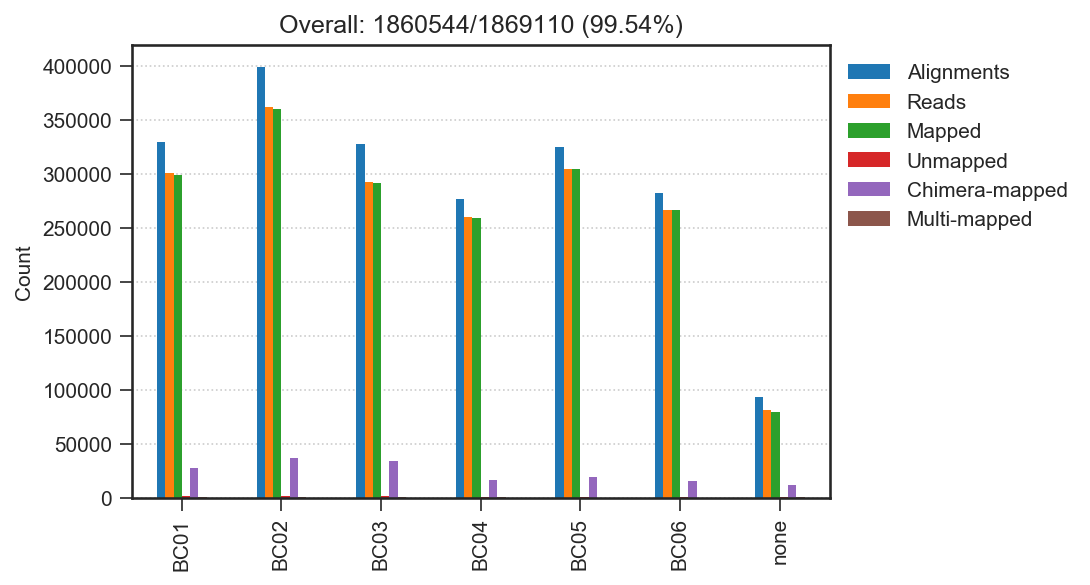

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot
mapping_df.plot(kind="bar", ax=ax)

# Labels
ax.set_title("Overall: %d/%d (%.02f%%)" % (totals["Mapped"], 
                                           totals["Reads"], 
                                           100*totals["Mapped"]/totals["Reads"]))
ax.set_ylabel("Count")
#ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax.set_xticklabels(mapping_df["ID"])

# Grid
ax.grid(axis='y', linestyle='dotted')

# Legend
ax.legend(bbox_to_anchor=(1, 1))

if save_figs:
    fig.savefig(os.path.join(fig_dir, "mapping_counts.png"),
                bbox_inches="tight",
                pad_inches=0.5)

###  2.2 Percentages

In [87]:
mapping_freqs = convert_to_frequencies(mapping_df, "Reads", "ID")

In [88]:
mapping_freqs

,ID,Alignments,Reads,Mapped,Unmapped,Chimera-mapped,Multi-mapped
0,BC01,1.094926,1.0,0.994442,0.005558,0.092798,0.002128
1,BC02,1.104350,1.0,0.994788,0.005212,0.102999,0.001351
2,BC03,1.118796,1.0,0.995091,0.004909,0.116791,0.002005
3,BC04,1.064409,1.0,0.995113,0.004887,0.062722,0.001687
4,BC05,1.064358,1.0,0.998403,0.001597,0.063302,0.001056
5,BC06,1.059164,1.0,0.997592,0.002408,0.057853,0.001311
6,none,1.148808,1.0,0.985602,0.014398,0.142565,0.006243


In [89]:
mapping_freqs.mean(0)

Alignments        1.093544
Reads             1.000000
Mapped            0.994433
Unmapped          0.005567
Chimera-mapped    0.091290
Multi-mapped      0.002254
dtype: float64

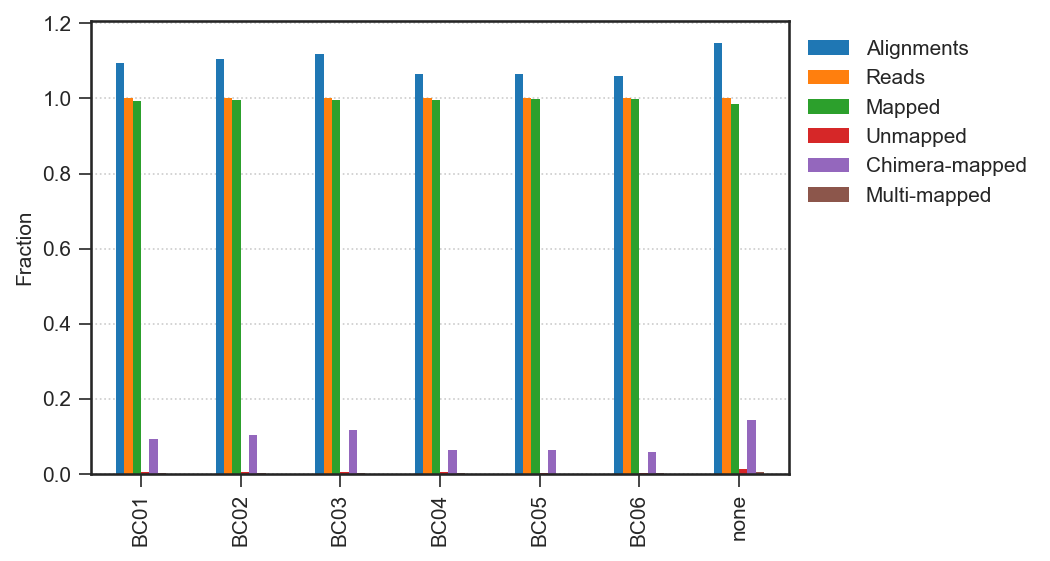

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot
mapping_freqs.plot(kind="bar", ax=ax)

# Scale
#ax.set_yscale("log")

# Labels
ax.set_ylabel("Fraction")
ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax.set_xticklabels(mapping_df["ID"])

# Grid
ax.grid(axis='y', linestyle='dotted')

# Legend
ax.legend(bbox_to_anchor=(1, 1))

if save_figs:
    fig.savefig(os.path.join(fig_dir, "mapping_freqs.png"),
                bbox_inches="tight",
                pad_inches=0.5)

TODO:
- This looks good
- A tabular output would be good
- A legend with the summary numbers
- A second "total" plot on the side